In [1]:
import data_loader as dl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.random.seed(0)

train_df, valid_df = dl.load_train_data("adult.data")
test_df = dl.load_test_data("adult.test")
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'martial.status',
                   'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
                   'hours.per.week', 'native.country', 'income']
train_df.columns = column_names
train_df.replace(' ?', np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(train_df)
imp_train_df = imp_mode.transform(train_df)
train_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    train_df[col] = train_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    train_df[col] = train_df[col].astype('category')
train_df['capital.gain.loss'] = train_df['capital.gain'] - train_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    train_df = pd.concat([train_df,pd.get_dummies(train_df[cat], prefix='is')],axis=1)
    train_df.drop([cat],axis=1, inplace=True)
train_df['income.prediction'] = train_df.income.cat.codes
train_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)

valid_df.columns = column_names
valid_df.replace(' ?', np.nan, inplace=True)
imp_train_df = imp_mode.transform(valid_df)
valid_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    valid_df[col] = valid_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    valid_df[col] = valid_df[col].astype('category')
valid_df['capital.gain.loss'] = valid_df['capital.gain'] - valid_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    valid_df = pd.concat([valid_df,pd.get_dummies(valid_df[cat], prefix='is')],axis=1)
    valid_df.drop([cat],axis=1, inplace=True)
valid_df['income.prediction'] = valid_df.income.cat.codes
valid_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)
missing_cols = set( train_df.columns ) - set( valid_df.columns )
for c in missing_cols:
    valid_df[c] = 0
valid_df = valid_df[train_df.columns]

test_df.columns = column_names
test_df.replace(' ?', np.nan, inplace=True)
imp_train_df = imp_mode.transform(test_df)
test_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    test_df[col] = test_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    test_df[col] = test_df[col].astype('category')
test_df['capital.gain.loss'] = test_df['capital.gain'] - test_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    test_df = pd.concat([test_df,pd.get_dummies(test_df[cat], prefix='is')],axis=1)
    test_df.drop([cat],axis=1, inplace=True)
test_df['income.prediction'] = test_df.income.cat.codes
test_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)
missing_cols = set( train_df.columns ) - set( test_df.columns )
for c in missing_cols:
    test_df[c] = 0
test_df = test_df[train_df.columns]

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

NUMBER_OF_LAYERS = 10
NUMBER_OF_NODES = 60

train = train_df.values
X, Y= train[:,:-1], train[:,-1]
valid = valid_df.values
Xval, Yval = valid[:,:-1], valid[:,-1]
test = test_df.values
Xtst, Ytst = test[:,:-1], test[:,-1]

model = Sequential()
model.add(Dense(NUMBER_OF_NODES, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.2))
for i in range(NUMBER_OF_LAYERS - 1):
    model.add(Dense(NUMBER_OF_NODES, activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                5040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_3 (Dropout)  

In [3]:
callback = [EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]
model.fit(X, Y, epochs=100, validation_data=(Xval, Yval), callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 29315 samples, validate on 3246 samples
Epoch 1/100
29315/29315 [==============================] - 8s 267us/step - loss: 0.6382 - acc: 0.7732 - val_loss: 0.4447 - val_acc: 0.8075
Epoch 2/100
29315/29315 [==============================] - 6s 199us/step - loss: 0.4168 - acc: 0.7901 - val_loss: 0.3926 - val_acc: 0.7853
Epoch 3/100
29315/29315 [==============================] - 6s 192us/step - loss: 0.3904 - acc: 0.7969 - val_loss: 0.3824 - val_acc: 0.7948
Epoch 4/100
29315/29315 [==============================] - 6s 188us/step - loss: 0.3779 - acc: 0.8059 - val_loss: 0.3861 - val_acc: 0.7754
Epoch 5/100
29315/29315 [==============================] - 6s 199us/step - loss: 0.3729 - acc: 0.8109 - val_loss: 0.3755 - val_acc: 0.8244
Epoch 6/100
29315/29315 [==============================] - 6s 201us/step - loss: 0.3701 - acc: 0.8170 - val_loss: 0.3808 - val_acc: 0.7988
Epoch 7/100
29315/29315 [==============================] - 5s 183us/s

In [4]:
def convertToClasses(input):
    output = np.zeros(len(input))
    for i in range(len(input)):
        if input[i] <= 0.5:
            output[i] = 0
        else:
            output[i] = 1
    return output

Yhat = model.predict(X)
tr_auc = roc_auc_score(Y, Yhat)
tr_acc = accuracy_score(Y, convertToClasses(Yhat))
Yhat = convertToClasses(model.predict(Xval))
va_auc = roc_auc_score(Yval, Yhat)
va_acc = accuracy_score(Yval, convertToClasses(Yhat))
Yhat = convertToClasses(model.predict(Xtst))
tst_auc = roc_auc_score(Ytst, Yhat)
tst_acc = accuracy_score(Ytst, convertToClasses(Yhat))

print("NN with 10 layers and 40 nodes")
print("Training AUC: {}".format(tr_auc))
print("Training ACC: {}".format(tr_acc))
print("Validation AUC: {}".format(va_auc))
print("Validation ACC: {}".format(va_acc))
print("Test AUC: {}".format(tst_auc))
print("Test ACC: {}".format(tst_acc))

NN with 10 layers and 40 nodes
Training AUC: 0.9042306110184234
Training ACC: 0.840457103871738
Validation AUC: 0.7022231025067728
Validation ACC: 0.8376463339494763
Test AUC: 0.7074366738240097
Test ACC: 0.8389533812419384


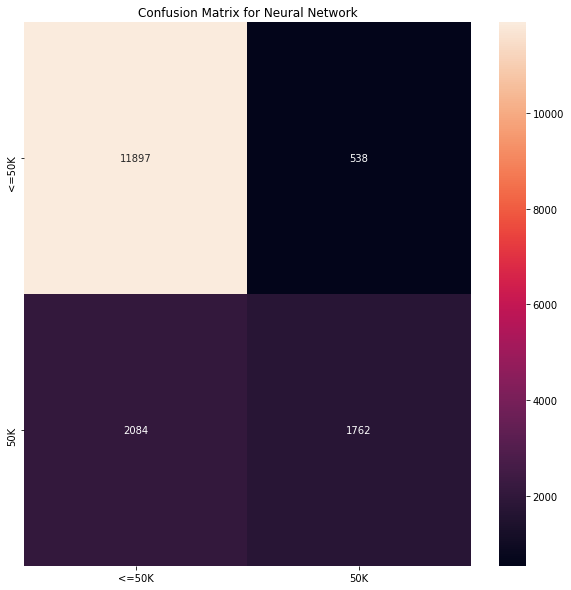

In [6]:
cm = confusion_matrix(Ytst, Yhat)
df_cm = pd.DataFrame(cm, index = [i for i in ["<=50K", "50K"]],
                  columns = [i for i in ["<=50K", "50K"]])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for Neural Network")
plt.show()